# Pretraining Encoder using BT
Adapted from https://github.com/nspunn1993/BT-Unet/blob/main/BT-Unet.ipynb 

In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
import copy
import random
from pretraining_functions import custom_augment, Unet_encoder, resnet50_encoder, WarmUpCosine, BarlowTwins, parse_images

## Hyper parameters

In [25]:
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
input_shape = (512, 512, 3)
width = input_shape[0]
batch_size = 32
model_path = os.path.join("..", "..", "..", "media", "FS2","models")

## Data Preparation

In [26]:
image_dir = os.path.join("..", "..", "..", "media", "FS2", "data", "pretraining_data", "png")

In [27]:
# images = []
# for subdir, dirs, files in os.walk(image_dir):
#     #files = random.sample(files, 100)
#     for file in files:
#         image = Image.open(os.path.join(image_dir, file)).convert('RGB')
#         np_original = np.asarray(image)
#         #images.append(tf.io.decode_png(tf.io.read_file(os.path.join(image_dir, file))))
#         images.append(np_original)

In [28]:
for subdir, dirs, files in os.walk(image_dir):
    new_files = [os.path.join(image_dir, file) for file in files]

In [29]:
len(new_files)

10726

In [30]:
 np.asarray(Image.open(new_files[0]).convert('RGB')).shape

(1500, 2500, 3)

In [31]:
def load_helper(file):
    image = np.asarray(Image.open(file.numpy()).convert('RGB'))
    return image
image_shape = (1500, 2500, 3)

In [32]:
def load_image(file):
    #print("in load image", file.numpy())
    #image = np.asarray(Image.open(file.numpy()).convert('RGB'))
    image = tf.py_function(load_helper, [file], tf.uint8)
    image.set_shape(image_shape)
    return image

In [33]:
ds = tf.data.Dataset.from_tensor_slices(new_files).map(lambda x: load_image(x))# tf.py_function(load_image2, [x], [tf.uint8]))#.map(lambda x: load_image(x))#images)
#ds = ds.flat_map(lambda x:  tf.data.Dataset.from_tensor_slices( tf.py_function(parse_images, (x, input_shape[0:2], 16), [tf.uint8]))) 
#ds = ds.batch(batch_size)#.flat_map(lambda x:  tf.data.Dataset.from_tensor_slices(parse_images(x, input_shape[0:2], 16))) # create tiles
# ds1 = ds1.unbatch() # flatted to images again
# ds2 = tf.data.Dataset.from_tensor_slices(images).map(lambda x: parse_images(x, input_shape[0:2], 16)) # create tiles
# ds2 = ds2.unbatch() # flatted to images again

In [34]:
ds

<_MapDataset element_spec=TensorSpec(shape=(1500, 2500, 3), dtype=tf.uint8, name=None)>

In [35]:
ds = ds.flat_map(lambda x:  tf.data.Dataset.from_tensor_slices(parse_images(x, input_shape[0:2], 16)))

## Data Augmentations

From https://github.com/nspunn1993/BT-Unet/tree/main 

## Augment data for pretraining

In [36]:
#ssl_ds_one = ds1 #tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ds.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

#ssl_ds_two = ds2 #tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ds.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))


## Encoder: Unet

In [37]:
input = tf.keras.layers.Input(shape=(input_shape[0], input_shape[1], 3))
encoder = Unet_encoder(input)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 512, 512, 16)      448       
                                                                 
 batch_normalization_10 (Ba  (None, 512, 512, 16)      64        
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 512, 512, 16)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 512, 512, 16)      2320      
                                                                 
 batch_normalization_11 (Ba  (None, 512, 512, 16)      64        
 tchNormalization)                                         

## BT model


In [38]:
PROJECT_DIM = width/2
batch_size = 4
EPOCHS = 50
WEIGHT_DECAY = 5e-4

STEPS_PER_EPOCH = len(new_files)*24 // batch_size
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

In [39]:
lr_decayed_fn = WarmUpCosine(
    learning_rate_base=1e-4,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

In [40]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)

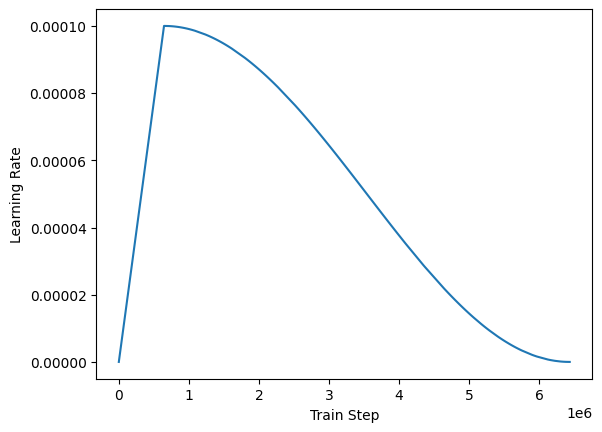

In [41]:
plt.plot(lr_decayed_fn(tf.range(EPOCHS*STEPS_PER_EPOCH, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [ ]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(model_path, "barlow_twins_UNET_cp"),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)

In [42]:
barlow_twins = BarlowTwins(encoder)
barlow_twins.compile(optimizer=optimizer)

In [45]:
history = barlow_twins.fit(ssl_ds, 
                           epochs=EPOCHS, 
                           callbacks=[early_stop_cb, model_ckpt_cb])

Epoch 1/100
    208/Unknown - 221s 978ms/step - loss: 160.3376

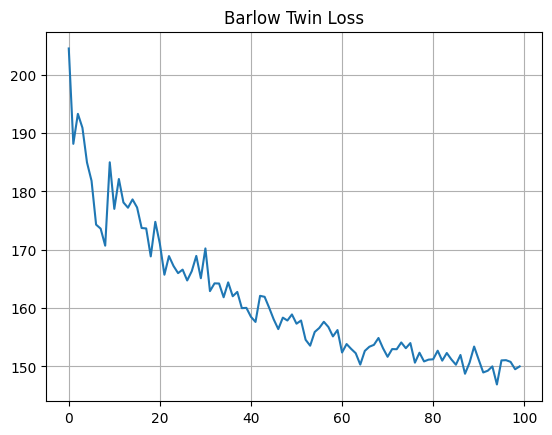

In [ ]:
plt.plot(history.history["loss"])
plt.grid()
plt.title("Barlow Twin Loss")
plt.show()

In [ ]:
barlow_twins.encoder.save(os.path.join(model_path, "barlow_twins_UNET"))

INFO:tensorflow:Assets written to: ../../../media/FS2/models/barlow_twins_UNET/assets


INFO:tensorflow:Assets written to: ../../../media/FS2/models/barlow_twins_UNET/assets


# Encoder: Resnet50

In [ ]:
input = tf.keras.layers.Input(shape=(input_shape[0], input_shape[1], 3))
encoder = resnet50_encoder(input)
encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
barlow_twins = BarlowTwins(encoder)
barlow_twins.compile(optimizer=optimizer)

In [ ]:
history = barlow_twins.fit(ssl_ds, epochs=EPOCHS)

Epoch 1/100
600/600 [==============================] - 132s 195ms/step - loss: nan
Epoch 2/100
600/600 [==============================] - 117s 196ms/step - loss: nan
Epoch 3/100
600/600 [==============================] - 118s 196ms/step - loss: nan
Epoch 4/100
600/600 [==============================] - 118s 196ms/step - loss: nan
Epoch 5/100
600/600 [==============================] - 118s 196ms/step - loss: nan
Epoch 6/100
600/600 [==============================] - 118s 196ms/step - loss: nan
Epoch 7/100
600/600 [==============================] - 118s 196ms/step - loss: nan
Epoch 8/100
600/600 [==============================] - 118s 196ms/step - loss: nan
Epoch 9/100
600/600 [==============================] - 118s 196ms/step - loss: nan
Epoch 10/100
600/600 [==============================] - 118s 196ms/step - loss: nan
Epoch 11/100
600/600 [==============================] - 118s 196ms/step - loss: nan
Epoch 12/100
600/600 [==============================] - 118s 196ms/step - loss: nan
E

KeyboardInterrupt: 

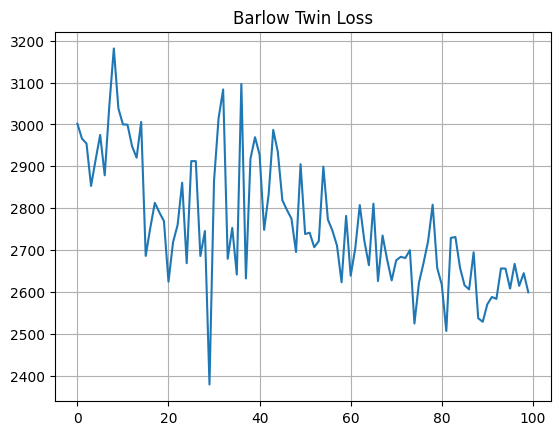

In [ ]:
plt.plot(history.history["loss"])
plt.grid()
plt.title("Barlow Twin Loss")
plt.show()

In [ ]:
barlow_twins.encoder.save(os.path.join(model_path, "barlow_twins_resnet"))

INFO:tensorflow:Assets written to: models/barlow_twins_resnet/assets


INFO:tensorflow:Assets written to: models/barlow_twins_resnet/assets
